In [1]:
from scipy.io import loadmat
from pathlib import Path as P
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib notebook
from ica_benchmark.sample.ica import sample_ica_data
from mne.epochs import Epochs
from ica_benchmark.processing.ica import CustomICA, get_all_methods, get_ica_instance
from scipy.stats import kurtosis


In [2]:
N = 20000
X, S, A = sample_ica_data(N, seed=10)
mean = np.array([[1, 2, 3, 4, 5, 6]]).T
X += mean

# Sources

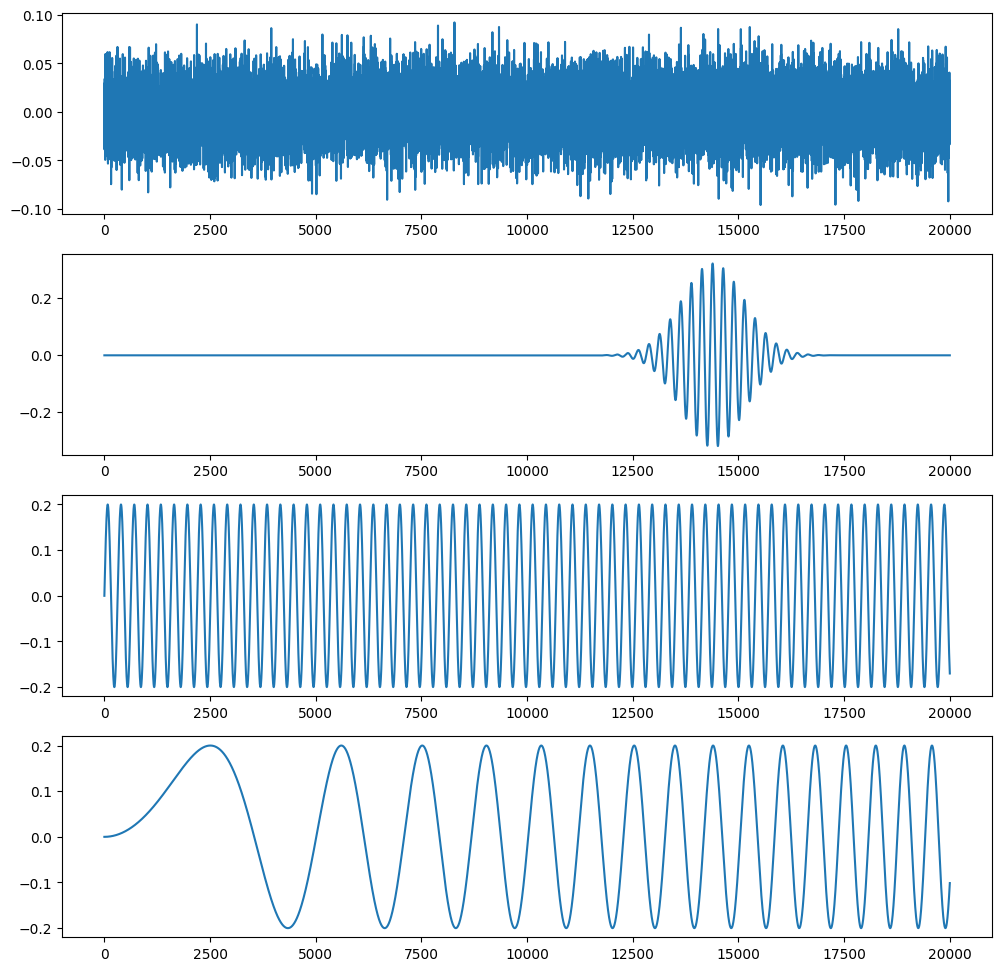

In [3]:
M = len(S)
fig, axes = plt.subplots(M, 1, figsize=(12, M * 3))
for c in range(M):
    axes[c].plot(S[c])

# Observed signals

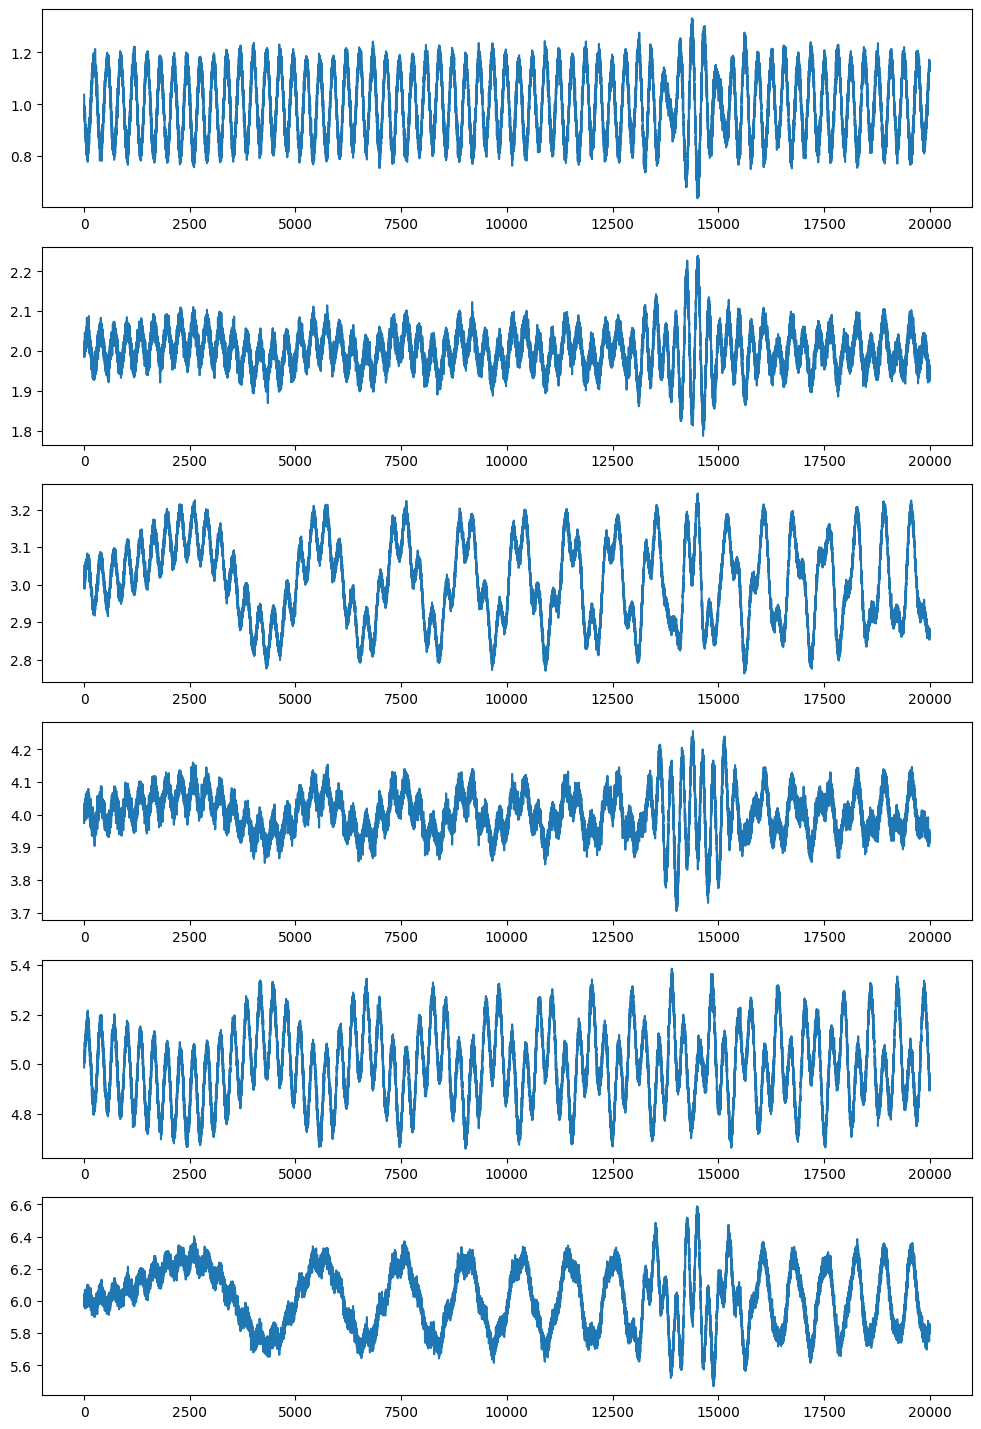

In [4]:
M = len(X)
fig, axes = plt.subplots(M, 1, figsize=(12, M * 3))
for c in range(M):
    axes[c].plot(X[c])

In [5]:
# https://mne.tools/dev/auto_tutorials/epochs/10_epochs_overview.html#creating-epoched-data-from-a-raw-object

M = len(X)
sampling_freq = 200  # in Hertz
info = mne.create_info(M, sfreq=sampling_freq, ch_types=["eeg"] * M)
simulated_raw_train = mne.io.RawArray(X[:, :15000], info)
simulated_raw_test = mne.io.RawArray(X[:, 15000:], info)


Running method 'fastica'.

Running method 'infomax'.

Running method 'picard'.

Running method 'ext_picard'.

Running method 'ext_infomax'.

Running method 'picard_o'.

Running method 'whitening'.

Running method 'pca'.

Running method 'sobi_coro'.

Running method 'choi_var'.

Running method 'choi_vartd'.

Running method 'choi_td'.

Running method 'coro'.

Running method 'jade'.

Running method 'sobi'.

Running method 'true'.


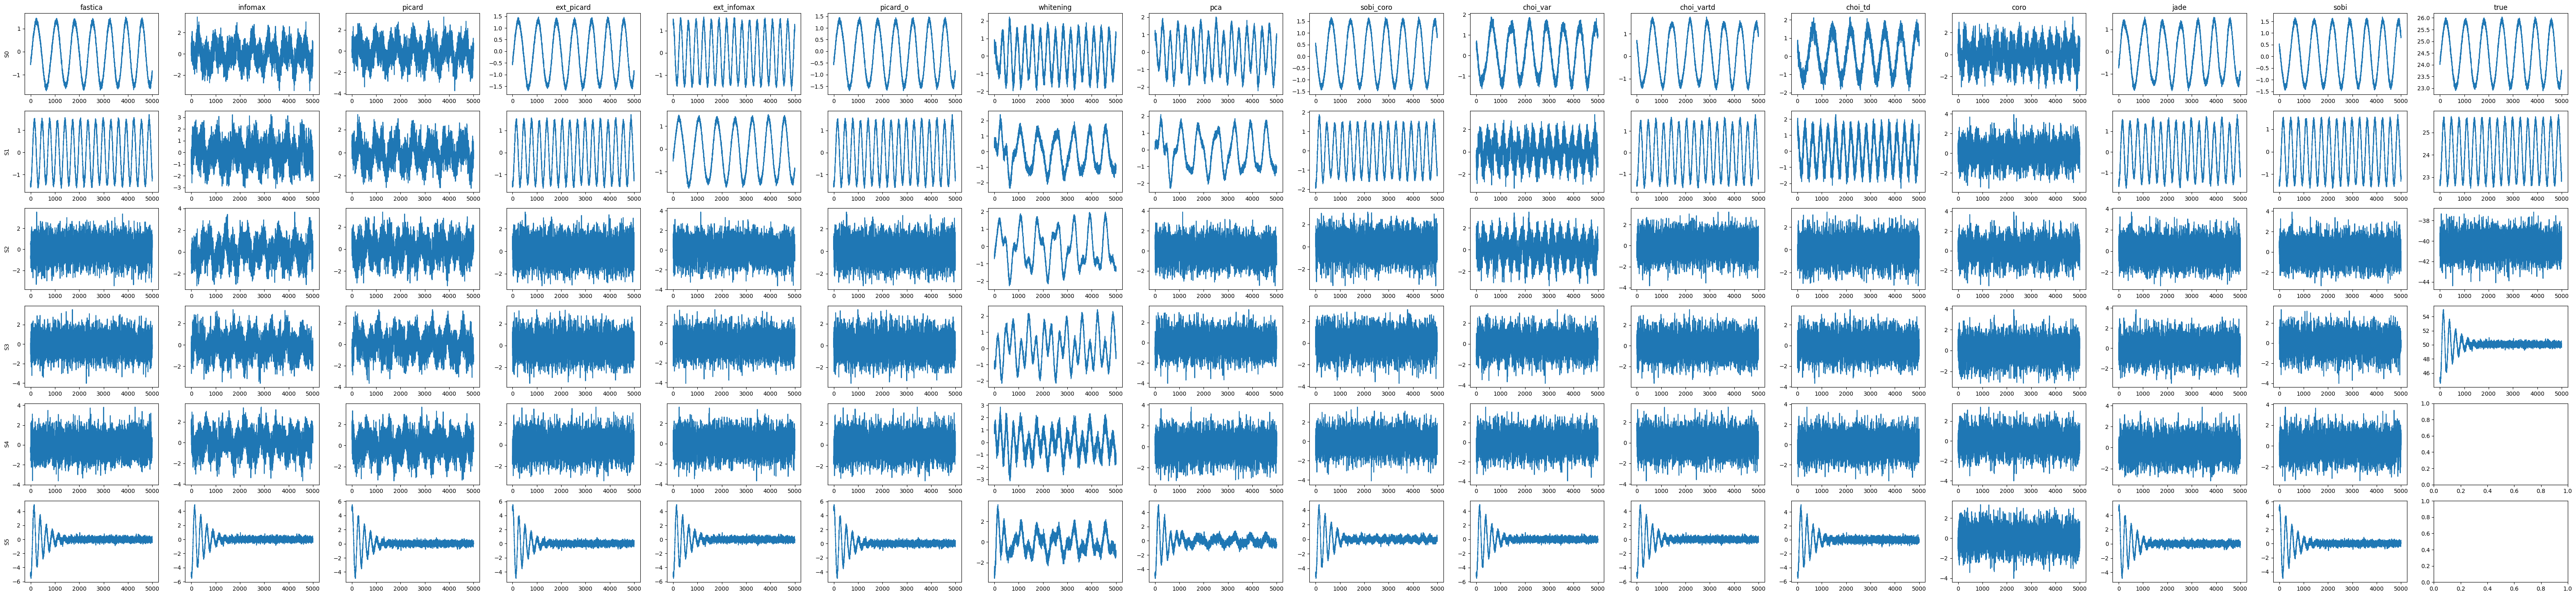

In [6]:
methods = get_all_methods()
methods = [m for m in methods if not "orica" in m.lower()] + ["true"]

n_methods = len(methods)
N_s = len(S)
N_x = len(X)

fig, axes = plt.subplots(N_x, n_methods, figsize=(n_methods * 5, N_x * 3))

ica_dict = dict()

for col, method in enumerate(methods):
    print("\nRunning method '{}'.".format(method), end=None)
    if method != "true":
        ica = get_ica_instance(method=method, random_state=42)
        ica.fit(simulated_raw_train)
        unmixing_matrix = ica.unmixing_matrix_
        estimated_sources = ica.transform(simulated_raw_test)
        S_hat = estimated_sources.get_data()
    else:
        unmixing_matrix = np.linalg.pinv(A)
        S_hat = np.linalg.pinv(A) @ X [:, 15000:]
        
    S_hat /= S_hat.std(axis=1, keepdims=True)
    S_hat = sorted(S_hat, key=kurtosis)
    
        
    ica_dict[method] = unmixing_matrix
    M = len(S_hat)
    
    
    for row, s_i in enumerate(S_hat):
        axes[row, col].plot(s_i)
        axes[row, 0].set_ylabel(f"S{row}")

    axes[0, col].set_title(method)
                

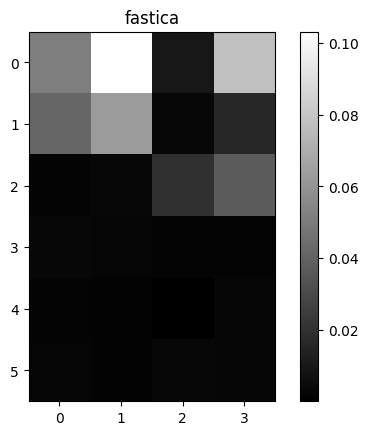

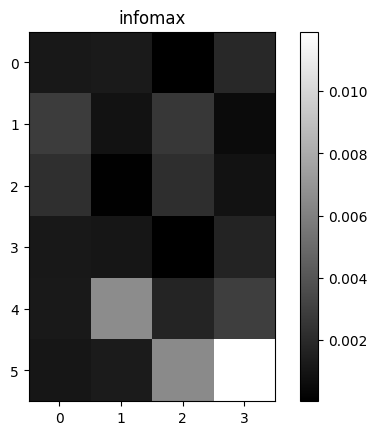

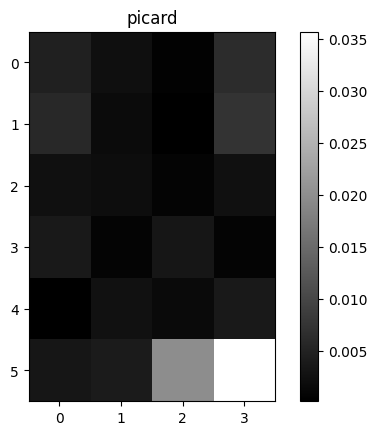

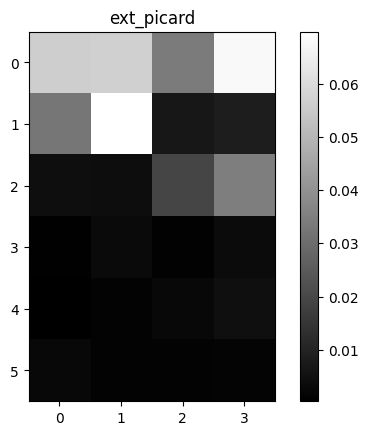

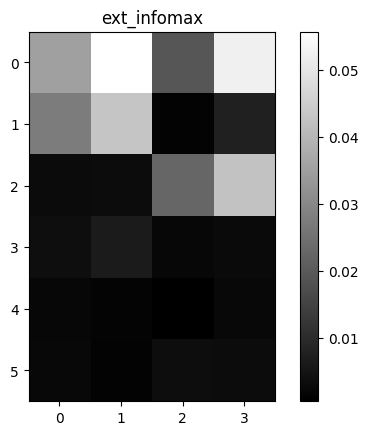

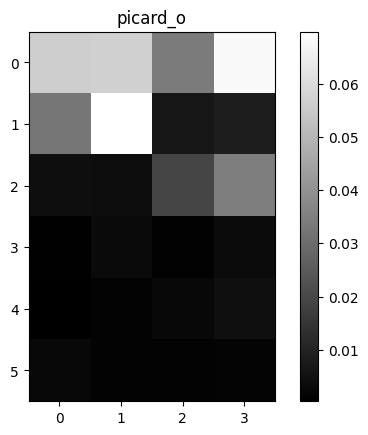

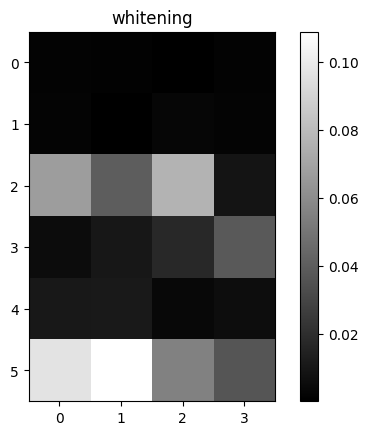

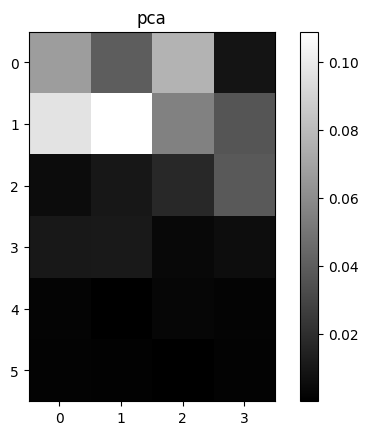

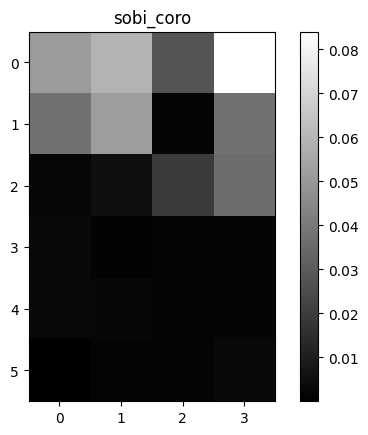

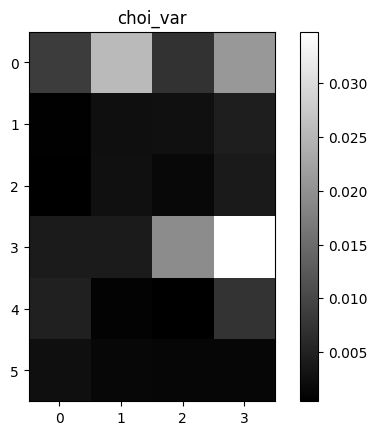

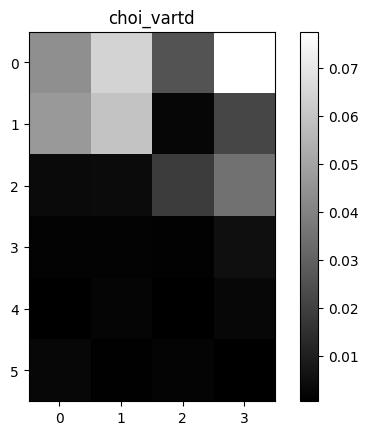

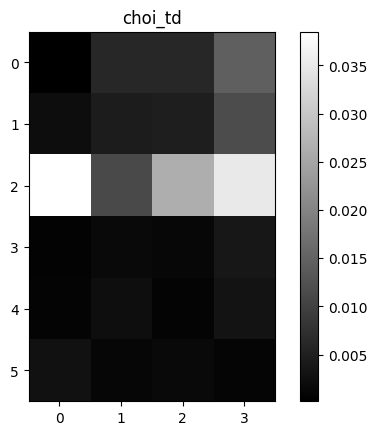

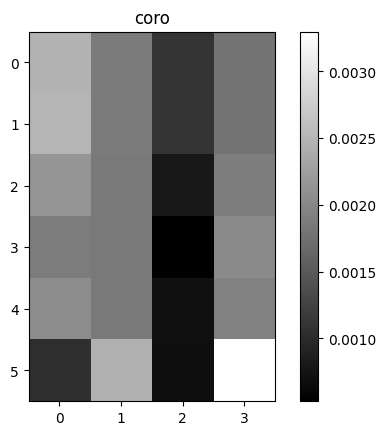

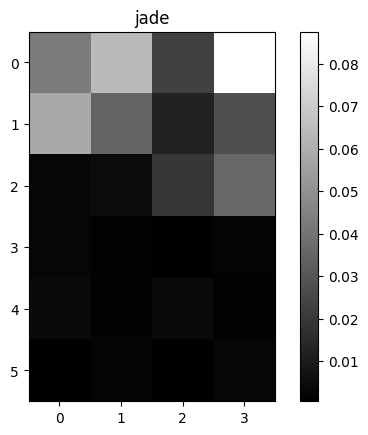

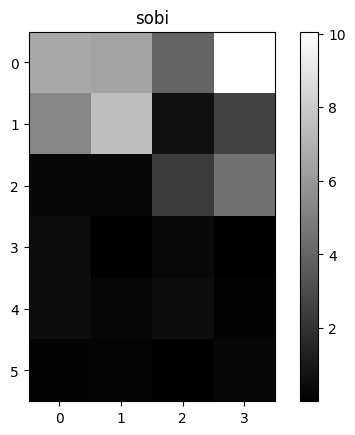

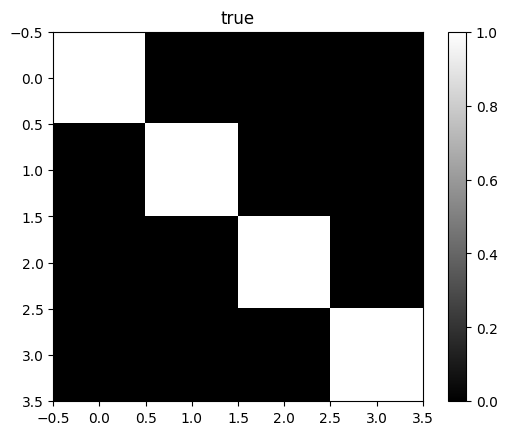

In [7]:
for method in methods:
    unminxing_matrix = ica_dict[method]
    r = unminxing_matrix @ A
    r /= (r ** 2).sum(axis=1, keepdims=True)
    r = np.abs(r)
    plt.imshow(r, cmap="gray")
    plt.title(method)
    plt.colorbar()
    plt.show()